# 실습: 성(姓) 분류

- 18개의 국가의 수천개의 성(姓)과 그 국가를 학습
- 스펠링 기반으로 이름이 어느나라 성(姓)인지 분류

In [1]:
import random
import time
import math
import torch
import torch.nn as nn

from pprint import pprint
from torch.autograd import Variable

In [2]:
DATA_PATH = "/home/ubuntu/practical-pytorch/data/"

## 데이터

In [3]:
import glob

all_filenames = glob.glob(DATA_PATH + "names/*.txt")

In [4]:
pprint(all_filenames)

['/home/ubuntu/practical-pytorch/data/names/French.txt',
 '/home/ubuntu/practical-pytorch/data/names/Greek.txt',
 '/home/ubuntu/practical-pytorch/data/names/Dutch.txt',
 '/home/ubuntu/practical-pytorch/data/names/Japanese.txt',
 '/home/ubuntu/practical-pytorch/data/names/Chinese.txt',
 '/home/ubuntu/practical-pytorch/data/names/English.txt',
 '/home/ubuntu/practical-pytorch/data/names/German.txt',
 '/home/ubuntu/practical-pytorch/data/names/Spanish.txt',
 '/home/ubuntu/practical-pytorch/data/names/Scottish.txt',
 '/home/ubuntu/practical-pytorch/data/names/Russian.txt',
 '/home/ubuntu/practical-pytorch/data/names/Italian.txt',
 '/home/ubuntu/practical-pytorch/data/names/Polish.txt',
 '/home/ubuntu/practical-pytorch/data/names/Arabic.txt',
 '/home/ubuntu/practical-pytorch/data/names/Irish.txt',
 '/home/ubuntu/practical-pytorch/data/names/Vietnamese.txt',
 '/home/ubuntu/practical-pytorch/data/names/Korean.txt',
 '/home/ubuntu/practical-pytorch/data/names/Portuguese.txt',
 '/home/ubuntu/pr

In [5]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드를 ASCII로 변환
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [6]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    # encoding 을 지정하지 않으면 오류 발생
    lines = open(filename, encoding="utf-8").read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

In [7]:
for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


In [8]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## 데이터 전처리(Turning Names into Tensors)

In [9]:
import torch

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [10]:
print(letter_to_tensor('o'))



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     1     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]



In [11]:
print(line_to_tensor('Koo'))


(0 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

(1 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

(2 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
[torch.FloatTensor of size 3x1x57]



## 네트워크 구성(Creating the Network)

![](https://i.imgur.com/Z2xbySO.png)

### 밑바닥부터 시작하는 RNN with Pytorch

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

## 간단한 네트워크 테스트(Manually testing the network)

In [13]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [14]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 18])


In [15]:
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.9841 -2.8408 -2.9261 -2.9806 -2.8041 -2.9934 -2.9377 -2.8403 -2.9406 -2.8359

Columns 10 to 17 
-2.9161 -2.8106 -2.8691 -2.7894 -2.8013 -3.0078 -2.9275 -2.8666
[torch.FloatTensor of size 1x18]



## 학습 준비

In [16]:
def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Dutch / line = Nagel
category = French / line = Delacroix
category = Korean / line = Suk
category = Portuguese / line = Castro
category = German / line = Nussbaum
category = German / line = Armbruster
category = Irish / line = Mcmahon
category = Korean / line = Ra
category = Japanese / line = Hamaguchi
category = Chinese / line = Mak


In [17]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Irish', 13)


## 학습

In [18]:
criterion = nn.NLLLoss()

In [19]:
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [20]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.data[0]

In [21]:
n_epochs = 30000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 16% (0m 25s) 2.5391 O'Neill / Dutch ✗ (Irish)
10000 33% (0m 51s) 1.5897 Tarantino / Italian ✓
15000 50% (1m 18s) 2.6357 Muraguchi / Italian ✗ (Japanese)
20000 66% (1m 43s) 4.5433 Pan / Vietnamese ✗ (French)
25000 83% (2m 6s) 1.7146 Klerx / Dutch ✓
30000 100% (2m 36s) 3.1632 Venne / French ✗ (Dutch)


## 학습 결과

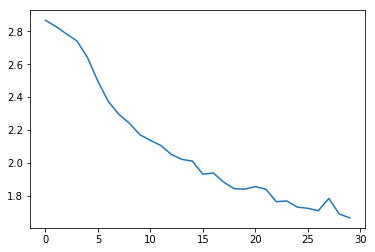

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## 검증

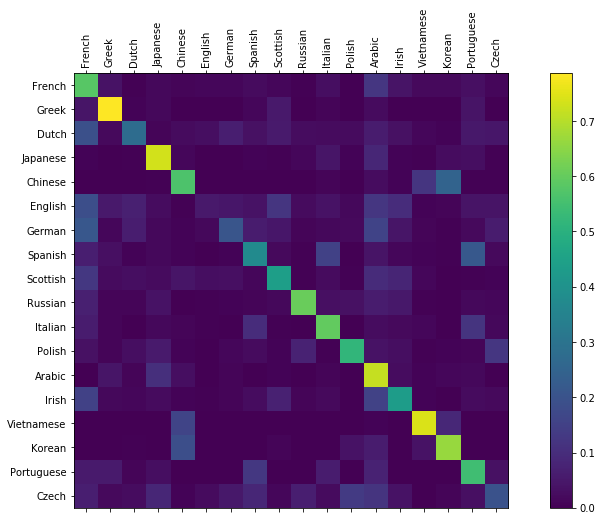

In [23]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## 예측 실행

In [24]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

In [25]:
predict('koo')
predict('Jackson')
predict('Satoshi')


> koo
(-0.25) Korean
(-2.75) Chinese
(-3.11) Scottish

> Jackson
(-1.34) Scottish
(-1.42) Russian
(-1.94) English

> Satoshi
(-0.87) Japanese
(-1.72) Italian
(-2.23) Arabic
